In [29]:
from kan import *
from torch.utils.data import DataLoader
from Modules import BaseDatasetPalm

In [30]:
torch.set_default_dtype(torch.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [31]:
dataset = BaseDatasetPalm('male',['SMSE','PR'])
dataset_f = BaseDatasetPalm('female',['SMSE','PR'])

Retrieving data from /home/u108-n256/PalmProject/NeuralNetwork_Testing/NN_Inputs/SMSE
Retrieving data from /home/u108-n256/PalmProject/NeuralNetwork_Testing/NN_Inputs/PR
Retrieving data from /home/u108-n256/PalmProject/NeuralNetwork_Testing/NN_Inputs/SMSE
Retrieving data from /home/u108-n256/PalmProject/NeuralNetwork_Testing/NN_Inputs/PR


In [32]:
X1 = torch.from_numpy(dataset.X[:,:,15::9].reshape(dataset.X.shape[0], -1,1)) #get the average relative humidity data
#X2 = torch.from_numpy(dataset.X[:,:,12::9].reshape(dataset.X.shape[0], -1,1)) #get the temperature data
#print(X1.shape, X2.shape)
#X = torch.cat((X1, X2), dim=2).reshape(-1,2) #concatenate the data
print(X1.shape)
time = torch.from_numpy(np.linspace(0, 1, X1.shape[1])).reshape(1, 800, 1).broadcast_to(X1.shape[0],800,1) #create a time tensor 
print(time.shape)
X = torch.cat((X1, time), dim=2).reshape(-1,2) #concatenate the data and time tensor

y1 = torch.from_numpy(np.where(dataset.y == 0, 0, 1)).reshape(dataset.X.shape[0],1,1).broadcast_to(dataset.X.shape[0],800,1).reshape(-1,1) #get the labels
y2 = torch.from_numpy(np.where(dataset_f.y == 0, 0, 1)).reshape(dataset.X.shape[0],1,1).broadcast_to(dataset.X.shape[0],800,1).reshape(-1,1) #get the labels
y3 = torch.where(y1 + y2 == 0, 1, 0) #get the labels
print(y3.shape)

y = torch.cat((y1, y2, y3), dim=1) #concatenate the labels

print(X.shape, y.shape)

torch.Size([55818, 800, 1])
torch.Size([55818, 800, 1])
torch.Size([44654400, 1])
torch.Size([44654400, 2]) torch.Size([44654400, 3])


In [33]:


X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]

#training_dl = DataLoader(list(zip(X_train, y_train)), batch_size=32, shuffle=True)
#test_dl = DataLoader(list(zip(X_test, y_test)), batch_size=32, shuffle=False)

dataset = {'train_input':X_train.to(device=device, dtype=torch.float32), 
           'test_input':X_test.to(device=device, dtype=torch.float32), 
           'train_label':y_train.to(device=device, dtype=torch.float32), 
           'test_label':y_test.to(device=device, dtype=torch.float32)}

As long as nothing is pruned everything works fine. But NaN occurs when the pruning thresholds are increased or the model is scaled up (some functions less important) in both cases pruning is triggered.

In [34]:
architecture = [2, 5, 3]
grid = 15

train_rmse = []
test_rmse = []

In [35]:

def inf(model, node_threshold=1e-2, edge_threshold=3e-2):
    print(f'\nNumber of active functions: {model.n_edge}\n')

    #model.attribute()
    
    edge_scores_layers =  len(model.edge_scores) if model.edge_scores is not None else None
    node_scores_layers = len(model.node_scores) if model.node_scores is not None else None

    #print(f'Edge Scores Layers: {model.edge_scores}')
    try:
        n_edges = [edge_scores.shape for edge_scores in model.edge_scores if edge_scores is not None]
    except TypeError:
        n_edges = None
    try:
        n_nodes = [node_scores.shape for node_scores in model.node_scores if node_scores is not None ]
    except TypeError:
        n_nodes = None
    
    act_edges = []
    act_nodes = []
    for edges, nodes in zip(model.edge_scores, model.node_scores):
        if edges is not None:
            act_edges.append(edges[edges > edge_threshold].shape[0])
        if nodes is not None:
            act_nodes.append(nodes[nodes > node_threshold].shape[0])
    
    masks =  [act_f.mask for act_f in model.act_fun]
    relative_masks = [(torch.sum(mask == 1)/mask.numel()).cpu().numpy() for mask in masks]


    print(f'\nEdge Scores Layers: {edge_scores_layers} with shapes: {n_edges} and {len(act_edges)} active edges\n')
    print(f'\nNode Scores Layers: {node_scores_layers} with shapes: {n_nodes} and {len(act_nodes)} active nodes\n')
    print(f'\nActive proportion of the Masks: {relative_masks}\n')
    print(f'\nGrid Size : {model.grid}')






In [36]:
def prune(self, node_th=1e-2, edge_th=3e-2, obs=True):
    #get activation functions
    if self.acts == None:
        self.get_act()

    if obs:
        print('Before edge pruning')
        inf(self)

    self.attribute()
    self.prune_edge(edge_th, log_history=False)

    if obs:
        print('After edge pruning')
        inf(self)
    
    self.forward(self.cache_data)
    self = self.prune_node(node_th, log_history=False)

    if obs:
        print('After node pruning')
        inf(self)
    self.log_history('prune')
    return self

In [37]:
# import torch

# with open('/home/u108-n256/PalmProject/NeuralNetwork_Testing/model/0.0_state', 'rb') as f:
#     model = pickle.load(f)

# model = torch.load('/home/u108-n256/PalmProject/NeuralNetwork_Testing/model/0.0_state')

In [38]:
#somehow the model.attribute() needs ti be called before pruning?????

model = MultKAN(width=architecture, grid=grid, k=3, seed=1, device=device)
test_loss = torch.inf
active_edges = torch.inf
lr=1e-5

df = {'Active Edges':[], 'Train Loss':[], 'Test Loss':[], 'Regularization':[]}
df_symb = {'Active Edges':[], 'Train Loss':[], 'Test Loss':[], 'Regularization':[]}

for i in range(5):
    results = model.fit(dataset, steps=20, batch=32, lr=lr, loss_fn=torch.nn.CrossEntropyLoss(), lamb=0.01)
    model = prune(model, obs=False)
    if test_loss < np.mean(results['test_loss']):
        test_loss = np.mean(results['test_loss'])
    # elif test_loss > np.mean(df['Test Loss'][-5:]) and i > 5:
    #     if lr > 1e-7:
    #         lr = lr/10

    df['Active Edges'].append(model.n_edge)
    df['Train Loss'].append(np.mean(results['train_loss']))
    df['Test Loss'].append(np.mean(results['test_loss']))
    df['Regularization'].append(np.mean(results['reg']))

    print(f'Epoch: {i}\nActive edges: {model.n_edge}\nLR:{lr}\n')        

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 1.08e+00 | test_loss: 1.10e+00 | reg: 8.00e+00 | : 100%|█| 20/20 [00:41<00:00,  2.06s/


saving model version 0.1
saving model version 0.2
Epoch: 0
Active edges: 25
LR:1e-05



| train_loss: 1.08e+00 | test_loss: 1.10e+00 | reg: 8.12e+00 | : 100%|█| 20/20 [00:39<00:00,  1.96s/


saving model version 0.3
saving model version 0.4
Epoch: 1
Active edges: 24
LR:1e-05



| train_loss: 1.08e+00 | test_loss: 1.10e+00 | reg: 8.17e+00 | : 100%|█| 20/20 [00:38<00:00,  1.93s/


saving model version 0.5
saving model version 0.6
Epoch: 2
Active edges: 24
LR:1e-05



| train_loss: 1.08e+00 | test_loss: 1.10e+00 | reg: 8.84e+00 | : 100%|█| 20/20 [00:38<00:00,  1.93s/


saving model version 0.7
saving model version 0.8
Epoch: 3
Active edges: 23
LR:1e-05



| train_loss: 1.08e+00 | test_loss: 1.10e+00 | reg: 9.35e+00 | : 100%|█| 20/20 [00:39<00:00,  1.96s/

saving model version 0.9
saving model version 0.10
Epoch: 4
Active edges: 23
LR:1e-05



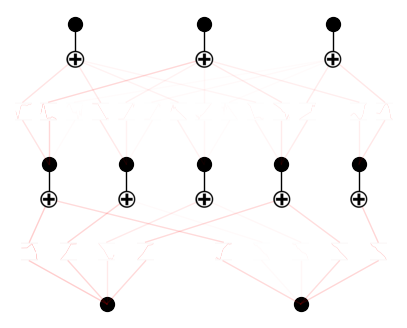

In [45]:
model.plot(beta=0.5)

fixing (0,0,0) with 0, r2=0.0, c=0
fixing (0,0,1) with 1/x^2, r2=0.9979313015937805, c=2
fixing (0,0,2) with 0, r2=0.0, c=0
fixing (0,0,3) with 0, r2=0.0, c=0
fixing (0,0,4) with 0
fixing (0,1,0) with 0, r2=0.0, c=0
fixing (0,1,1) with x, r2=0.9841940402984619, c=1
fixing (0,1,2) with x, r2=0.9683363437652588, c=1
fixing (0,1,3) with x, r2=0.9938626289367676, c=1
fixing (0,1,4) with x, r2=0.9923510551452637, c=1
fixing (1,0,0) with 0, r2=0.0, c=0
fixing (1,0,1) with 0, r2=0.0, c=0
fixing (1,0,2) with 0, r2=0.0, c=0
fixing (1,1,0) with 1/x^2, r2=0.997524619102478, c=2
fixing (1,1,1) with 0, r2=0.0, c=0
fixing (1,1,2) with 0, r2=0.0, c=0
fixing (1,2,0) with 0, r2=0.0, c=0
fixing (1,2,1) with 0, r2=0.0, c=0
fixing (1,2,2) with 0, r2=0.0, c=0
fixing (1,3,0) with 0, r2=0.0, c=0
fixing (1,3,1) with 0, r2=0.0, c=0
fixing (1,3,2) with 0, r2=0.0, c=0
fixing (1,4,0) with 0
fixing (1,4,1) with 0, r2=0.0, c=0
fixing (1,4,2) with 0, r2=0.0, c=0
saving model version 0.11


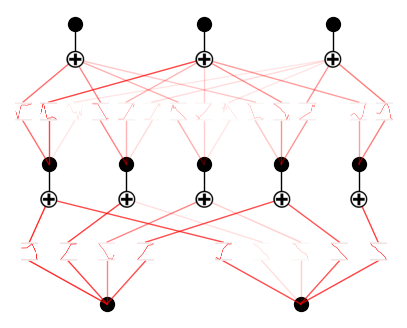

In [40]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model1 = model
model1.auto_symbolic()
model1.plot()

In [41]:
model1.symbolic_formula()[0][0]


-0.047676885034889 + 0.00304878963925133/(0.105151263289206*x_2 - 1 + 0.0168095100346607/(0.283435513476539 - x_1)**2)**2

In [42]:
model1.symbolic_formula()[0][1]


0.0339957871474326

In [44]:
model1.symbolic_formula()[0][2]


-0.0521588441915810

saving model version 0.12


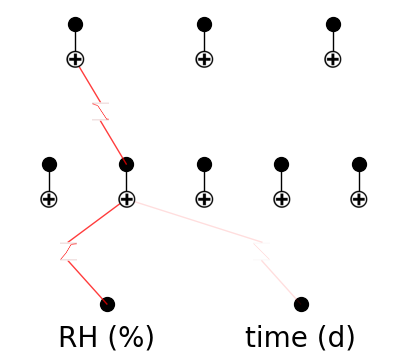

In [47]:
model2 = model.prune(1e-2, 3e-2)
model2.plot(in_vars=['RH (%)','time (d)'])